In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf


In [2]:
aa="AGSTNQVILMFYWHPKREDC" #The twenty amino acids, grouped somewhat by feature

In [3]:
aapairs=np.zeros((20,20))


In [4]:
#Helper functions 

def seqpair_tokenize(seq):
    #Takes a single-character protein sequence, returns a 20x20 ndarray with the frequencies of sequence neighbors 
    prev=""
    cur=""
    second=""
    aapairs=np.zeros((20,20))
    wl=1/len(seq)
    for c in seq:
        try:
            cur=aa.index(c)
        except ValueError:
            prev=""
        if prev:
            aapairs[prev,cur]+=wl
    
        prev=cur
    return aapairs
def seqplusonepair_tokenize(seq):
    #Takes a single-character protein sequence, returns a 20x20 ndarray with the frequencies of sequence neighbors 
    prev=""
    cur=""

    second=""
    third=""
    aapairs=np.zeros((20,20))
    wl=1/len(seq)
    for c in seq:
        try:
            cur=aa.index(c)
        except ValueError:
            prev=""
            third=""
        if third:
            aapairs[third,cur]+=wl
        third=second
        second=cur
    return aapairs
def PsychOrNot(classification):
    if classification == "Thermo":
        return 1
    else:
        return 0
            

In [5]:
#Dataset consists of sequences downloaded from PDB based on searches for Psychrophil* and Thermophil*
dataset=pd.read_csv("dataset/database-pdb.csv",names=("Classification","Label","Sequence"))


dataset["AApairs"]=dataset["Sequence"].map(seqpair_tokenize)
dataset["codes"]=dataset["Label"].map(PsychOrNot)

In [6]:
dataset=pd.concat((dataset.loc[dataset["Label"] == "Thermo"].sample(len(dataset.loc[dataset["Label"] == "Psychro"])),dataset.loc[dataset["Label"] == "Psychro"]))
dataset

,Classification,Label,Sequence,AApairs,codes
294,1,Thermo,QSGPVIRVAGDSTAVGEGGRWMKEMVEAWGKKTGTRVEYIDSPADT...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
378,38,Thermo,MKGILGVKVGMTRIFRDDRAVPVTVILAGPCPVVQRRTPEKDGYTA...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
403,1,Thermo,VPYSSAQ,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
358,47,Thermo,RHLKSGRKLNRHSSHRLALYRNQAKSLLTHGRITTTVPKAKELRGF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
356,52,Thermo,MEAKAIARYVRISPRKVRLVVDLIRGKSLEEARNILRYTNKRGAYF...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
...,...,...,...,...,...
246,1,Psychro,MKLGVCYYPEHWPKSRWVEDAQHMRRIGIQYVRVGEFSWSTIEPTP...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
247,1,Psychro,AFELPSLPYAIDALEPHISKETLEFHHGKHHNTYVVKLNGLIPGTK...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
248,1,Psychro,MRGSHHHHHHGMASMTGGQQMGRDLYDDDDKDHPFTMTSLFAAIQP...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
249,1,Psychro,MGSSHHHHHHSSGLVPRGSHMILVTGALGQIGTELVLALQEKYGND...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0


In [7]:
#Need to split the dataset into train,test and validation
from sklearn.model_selection import train_test_split

x, x_test, y, y_test = train_test_split(dataset["AApairs"],dataset["codes"],test_size=0.2,train_size=0.8)
x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size = 0.5,train_size =0.5)

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices((np.split(x,1),np.split(y,1)))
test_dataset = tf.data.Dataset.from_tensor_slices((np.split(x_test,1),np.split(y_test,1)))
validate_dataset = tf.data.Dataset.from_tensor_slices((np.split(x_cv,1),np.split(y_cv,1)))
train_dataset

<TensorSliceDataset shapes: ((401, 20, 20), (401,)), types: (tf.float64, tf.int32)>

In [9]:
#tf.data.experimental.save(validate_dataset,"validate.tf")
#tf.data.experimental.save(train_dataset,"train.tf")
#tf.data.experimental.save(test_dataset,"test.tf")

In [10]:
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 100
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
#test_dataset = test_dataset.batch(BATCH_SIZE)


In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(20, 20)),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['sparse_categorical_accuracy'])
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
#model.compile(loss='categorical_crossentropy', optimizer=opt)

In [12]:
model.fit(train_dataset, epochs=200,batch_size=256)

Epoch 1/200
1/1 [==============================] - 1s 620ms/step - loss: 0.6927 - sparse_categorical_accuracy: 0.4988
Epoch 2/200
1/1 [==============================] - 0s 10ms/step - loss: 0.6900 - sparse_categorical_accuracy: 0.5262
Epoch 3/200
1/1 [==============================] - 0s 7ms/step - loss: 0.6879 - sparse_categorical_accuracy: 0.5736
Epoch 4/200
1/1 [==============================] - 0s 8ms/step - loss: 0.6859 - sparse_categorical_accuracy: 0.5985
Epoch 5/200
1/1 [==============================] - 0s 11ms/step - loss: 0.6838 - sparse_categorical_accuracy: 0.6484
Epoch 6/200
1/1 [==============================] - 0s 5ms/step - loss: 0.6816 - sparse_categorical_accuracy: 0.6658
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 0.6796 - sparse_categorical_accuracy: 0.7007
Epoch 8/200
1/1 [==============================] - 0s 11ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.6958
Epoch 9/200
1/1 [==============================] - 0s 13ms/step - 

1/1 [==============================] - 0s 8ms/step - loss: 0.5488 - sparse_categorical_accuracy: 0.9002
Epoch 70/200
1/1 [==============================] - 0s 8ms/step - loss: 0.5464 - sparse_categorical_accuracy: 0.9002
Epoch 71/200
1/1 [==============================] - 0s 8ms/step - loss: 0.5441 - sparse_categorical_accuracy: 0.9027
Epoch 72/200
1/1 [==============================] - 0s 9ms/step - loss: 0.5418 - sparse_categorical_accuracy: 0.9002
Epoch 73/200
1/1 [==============================] - 0s 8ms/step - loss: 0.5395 - sparse_categorical_accuracy: 0.9027
Epoch 74/200
1/1 [==============================] - 0s 10ms/step - loss: 0.5372 - sparse_categorical_accuracy: 0.8978
Epoch 75/200
1/1 [==============================] - 0s 11ms/step - loss: 0.5349 - sparse_categorical_accuracy: 0.9027
Epoch 76/200
1/1 [==============================] - 0s 7ms/step - loss: 0.5326 - sparse_categorical_accuracy: 0.8978
Epoch 77/200
1/1 [==============================] - 0s 12ms/step - loss: 0.

Epoch 137/200
1/1 [==============================] - 0s 8ms/step - loss: 0.4017 - sparse_categorical_accuracy: 0.9152
Epoch 138/200
1/1 [==============================] - 0s 8ms/step - loss: 0.3998 - sparse_categorical_accuracy: 0.9152
Epoch 139/200
1/1 [==============================] - 0s 9ms/step - loss: 0.3979 - sparse_categorical_accuracy: 0.9152
Epoch 140/200
1/1 [==============================] - 0s 9ms/step - loss: 0.3960 - sparse_categorical_accuracy: 0.9152
Epoch 141/200
1/1 [==============================] - 0s 7ms/step - loss: 0.3941 - sparse_categorical_accuracy: 0.9177
Epoch 142/200
1/1 [==============================] - 0s 7ms/step - loss: 0.3922 - sparse_categorical_accuracy: 0.9152
Epoch 143/200
1/1 [==============================] - 0s 11ms/step - loss: 0.3904 - sparse_categorical_accuracy: 0.9152
Epoch 144/200
1/1 [==============================] - 0s 5ms/step - loss: 0.3885 - sparse_categorical_accuracy: 0.9152
Epoch 145/200
1/1 [==============================] - 0s

In [13]:
model.evaluate(validate_dataset)

1/1 [==============================] - 0s 163ms/step - loss: 0.2633 - sparse_categorical_accuracy: 0.9602


[0.2632850706577301, 0.9601989984512329]

In [14]:
model.save("psychornot-keras")

INFO:tensorflow:Assets written to: psychornot-keras\assets


In [15]:
def predict_sequence(model,seq):
    tokenized=(np.expand_dims(seqpair_tokenize(seq),0))
    prediction= model.predict(tokenized)
    classes=["Psychrophillic","Thermophillic"]
    return classes[prediction.argmax()]
def predict_sequence_score(model,seq):
    tokenized=(np.expand_dims(seqpair_tokenize(seq),0))
    prediction= model.predict(tokenized)
    return prediction

In [16]:
#B.lichienformis A-amylase (thermophillic), still some. 
seq="MKQQKRLYARLLTLLFALIFLLPHSAAAAANLNGTLMQYFEWYMPNDGQHWKRLQNDSAYLAEHGITAVWIPPAYKGTSQADVGYGAYDLYDLGEFHQKGTVRTKYGTKGELQSAIKSLHSRDINVYGDVVINHKGGADATEDVTAVEVDPADRNRVISGEHRIKAWTHFHFPGRGSTYSDFKWHWYHFDGTDWDESRKLNRIYKFQGKAWDWEVSNENGNYDYLMYADIDYDHPDVAAEIKRWGTWYANELQLDGFRLDAVKHIKFSFLRDWVNHVREKTGKEMFTVAEYWQNDLGALENYLNKTNFNHSVFDVPLHYQFHAASTQGGGYDMRKLLNSTVVSKHPLKAVTFVDNHDTQPGQSLESTVQTWFKPLAYAFILTRESGYPQVFYGDMYGTKGDSQREIPALKHKIEPILKARKQYAYGAQHDYFDHHDIVGWTREGDSSVANSGLAALITDGPGGAKRMYVGRQNAGETWHDITGNRSEPVVINSEGWGEFHVNGGSVSIYVQR"
predict_sequence(model,seq)

'Psychrophillic'

In [17]:
#Pseudoalteromonas haloplanktis A-amylase (psychrophillic)

seq="MKLNKIITTAGLSLGLLLPSIATATPTTFVHLFEWNWQDVAQECEQYLGPKGYAAVQVSPPNEHITGSQWWTRYQPVSYELQSRGGNRAQFIDMVNRCSAAGVDIYVDTLINHMAAGSGTGTAGNSFGNKSFPIYSPQDFHESCTINNSDYGNDRYRVQNCELVGLADLDTASNYVQNTIAAYINDLQAIGVKGFRFDASKHVAASDIQSLMAKVNGSPVVFQEVIDQGGEAVGASEYLSTGLVTEFKYSTELGNTFRNGSLAWLSNFGEGWGFMPSSSAVVFVDNHDNQRGHGGAGNVITFEDGRLYDLANVFMLAYPYGYPKVMSSYDFHGDTDAGGPNVPVHNNGNLECFASNWKCEHRWSYIAGGVDFRNNTADNWAVTNWWDNTNNQISFGRGSSGHMAINKEDSTLTATVQTDMASGQYCNVLKGELSADAKSCSGEVITVNSDGTINLNIGAWDAMAIHKNAKLNTSSASSTESDWQRTVIFINAQTQSGQDMFIRGGIDHAYANANLGRNCQTSNFECAMPIRHNNLKNVTTSPWKANDNYLDWYGIENGQSSEAEGSATDWTTNVWPAGWGAEKTVNTDGFGVTPLNIWGEHYWMLDVDMDCSKAVNGWFELKAFIKNGQGWETAIAQDNAPYTSTNHMAQCGKINKFEFNNSGVVIRSF"
predict_sequence(model,seq)

'Psychrophillic'

In [18]:
%%time
#Salmon elastase
seq="VVGGRVAQPNSWPWQISLQYKSGSSYYHTCGGSLIRQGWVMTAAHCVDSARTWRVVLGEHNLNTNEGKEQIMTVNSVFIHSGWNSDDVAGGYDIALLRLNTQASLNSAVQLAALPPSNQILPNNNPCYITGWGKTSTGGPLSDSLKQAWLPSVDHATCSSSGWWGSTVKTTMVCAGGGANSGCNGDSGGPLNCQVNGSYYVHGVTSFVSSSGCNASKKPTVFTRVSAYISWMNGIM"
predict_sequence(model,seq)

Wall time: 66.8 ms


'Psychrophillic'

In [19]:
#Vibrio AP
seq="MKPIVTAVVTSTLSFNVLSAEIKNVILMIGDGMGPQQVGLLETYANQAPNSIYKGNKTAIYQLAQEGVIGSSLTHPEDAIVVDSACSATMLATGIYSSSEVIGIDSQGNHVETVLEKAKKAGKATGLVSDTRLTHATPASFAAHQPHRSLENQIASDMLATGADVMLSGGLRHWIPKSTNDKGETYKQLEKLTQGDVYLKSKRKDDRNLLTEAEKDGYQLAFNRNMLDDAKGDKLLGLFAYSGMDDGIAYSNKKKSGERTQPSLKEMTQKALNILSKDEDGFFLMVEGGQIDWAGHSNDAGTMLHELLKFDEAIQTVYEWAKDREDTIVIVTADHETGSFGFSYSSNDLPKPQKRSGEAFADRDYAPNFNFGAFDILDGLYNQKQSYYGMISEFQKLDKSLQTPEKLAEIVNKNSEFPITAEQAKNVLASKPNPYRLAQHKYLSAEEVPAINDFDAFFPYNDRGNLLAREQATGQNIVWGTGTHTHTPVNVFAWGPAEKILPVSKIMHHSELGEYIKQQVN"
predict_sequence(model,seq)

'Psychrophillic'

In [20]:
#hyperthermophile
seq="MLNIYLKSKIHMATITRKEVYYEGSIEIDEELMGKAGISEGELVLVVNVNNAERFVTYVIKGKRGSREINLYGAAARLGEEGDRVIIMAFTFSDKPVKAKTIVLNEKNEIVQEK"
predict_sequence(model,seq)

'Thermophillic'

In [21]:
#thermophile
seq="MKKVGILNSEISKIVADMGHMDTLAVVDLGFPIPQGVKKVDLVVDRGKPGLMEVIEILLRELKVERIILAKEMDEKSIQTKQELLKLIEKMNGPVEVVTVPHKEFKEMSKNVKGIIRTGADIPYSNVILVGGVIF"
predict_sequence(model,seq)

'Thermophillic'

In [22]:
seq="AFNNNPSSVGAYSSGTYRNLAQEMGKTNIQQKVNSTFDNMFGYNNTQQLYYPYTENGVYKAHYIKAINPDEGDDIRTQGQSWGMTAAVMLNKQEEFDNLWRFAKAYQKNPDNHPDAKKQGVYAWKLKLNQNGFVYKVDEGPAPDGEEYFAFALLNASARWGNSGEFNYYNDAITMLNTIKNKLMENQIIRFSPYIDNLTDPSYHIPAFYDYFANNVTNQADKNYWRQVATKSRTLLKNHFTKVSGSPHWNLPTFLSRLDGSPVIGYIFNGQANPGQWYEFDAWRVIMNVGLDAHLMGAQAWHKSAVNKALGFLSYAKTNNSKNCYEQVYSYGGAQNRGCAGEGQKAANAVALLASTNAGQANEFFNEFWSLSQPTGDYRYYNGSLYMLAMLHVSGNFKFYNNTFN"
predict_sequence(model,seq)

'Psychrophillic'

In [23]:
%%time
#mesophile
seq="MKLFLLLSAFGFCWAQYAPQTQSGRTSIVHLFEWRWVDIALECERYLGPKGFGGVQVSPPNENIVVTNPSRPWWERYQPVSYKLCTRSGNENEFRDMVTRCNNVGVRIYVDAVINHMCGSGAAAGTGTTCGSYCNPGNREFPAVPYSAWDFNDGKCKTASGGIESYNDPYQVRDCQLVGLLDLALEKDYVRSMIADYLNKLIDIGVAGFRIDASKHMWPGDIKAVLDKLHNLNTNWFPAGSRPFIFQEVIDLGGEAIQSSEYFGNGRVTEFKYGAKLGTVVRKWSGEKMSYLKNWGEGWGFMPSDRALVFVDNHDNQRGHGAGGASILTFWDARLYKVAVGFMLAHPYGFTRVMSSYRWARNFVNGQDVNDWIGPPNNNGVIKEVTINADTTCGNDWVCEHRWRQIRNMVWFRNVVDGQPFANWWANGSNQVAFGRGNRGFIVFNNDDWQLSSTLQTGLPGGTYCDVISGDKVGNSCTGIKVYVSSDGTAQFSISNSAEDPFIAIHAESKL"
predict_sequence_score(model,seq)

Wall time: 95.7 ms


array([[ 0.5350865, -0.6710557]], dtype=float32)

In [ ]:
#Not machine-learning directly, but visualize the features extracted from the sequences

In [24]:
averagepsychro=np.average(dataset["AApairs"].loc[dataset["Label"]=="Psychro"])
averagethermo=np.average(dataset["AApairs"].loc[dataset["Label"]=="Thermo"])
difference = averagepsychro-averagethermo

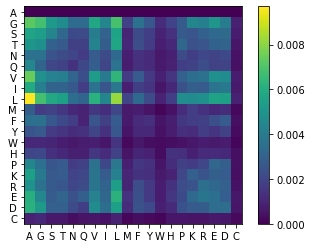

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)
img = ax.imshow(averagepsychro)
ax.set_xticks(range(0,20))
ax.set_yticks(range(0,20))

#io.imshow(difference)
ax.set_xticklabels(aa)
ax.set_yticklabels(aa)
fig.colorbar(img)


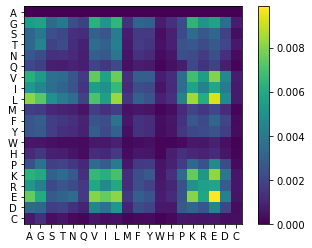

In [26]:
fig, ax = plt.subplots(1,1)
img = ax.imshow(averagethermo)
ax.set_xticks(range(0,20))
ax.set_yticks(range(0,20))

#io.imshow(difference)
ax.set_xticklabels(aa)
ax.set_yticklabels(aa)
fig.colorbar(img)


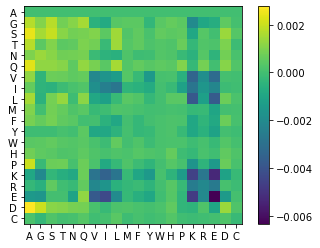

In [27]:

fig, ax = plt.subplots(1,1)
img = ax.imshow(difference)
ax.set_xticks(range(0,20))
ax.set_yticks(range(0,20))

#io.imshow(difference)
ax.set_xticklabels(aa)
ax.set_yticklabels(aa)
fig.colorbar(img)


In [28]:
y_pred=model.predict(train_dataset) #Calculate predicted values for the training dataset 
ypred=y_pred.argmax(axis=1)

In [24]:
from sklearn import metrics #Build a confusion matrix to check for false positives, false negatives etc.
confmatrix=metrics.confusion_matrix(y,ypred)
metrics.ConfusionMatrixDisplay(confmatrix).plot()

NameError: name 'ypred' is not defined